# Data structuring

In [1]:
# Loading packages

import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [2]:
# Load df from disk

df = pd.read_csv("speeches/data.csv")

In [3]:
#removing the index coloumn 
df.head()

,Name,Date,Speech,Type,Party
0,Donald Trump,"February 05, 2019","\r\n \r\n \r\nMadam Speaker, Mr. Vic...",State of the Union,Republican
1,Donald Trump,"January 30, 2018","\r\n \r\n Mr. Speaker, Mr. Vice Pres...",State of the Union,Republican
2,Donald Trump,"January 20, 2017","\r\n \r\n Chief Justice Roberts, Pre...",Inaugural Address,Republican
3,Barack Obama,"January 12, 2016","\r\n \r\n Mr. Speaker, Mr. Vice Pres...",State of the Union,Democrat
4,Barack Obama,"January 20, 2015","\r\n \r\n Mr. Speaker, Mr. Vice Pres...",State of the Union,Democrat


In [4]:
len(df)

250

In [5]:
df["Speech"] = df["Speech"].str.replace("transcript-inner", "").str.replace(u'\xa0', u' ')

In [6]:
print(df['Speech'].loc[9])


      
      Mr. Speaker, Mr. Vice President, members of Congress, distinguished guests, and fellow Americans:

      Tonight I want to begin by congratulating the men and women of the 112th Congress, as well as your new Speaker, John Boehner.  (Applause.)  And as we mark this occasion, we’re also mindful of the empty chair in this chamber, and we pray for the health of our colleague -- and our friend -– Gabby Giffords.  (Applause.)

      It’s no secret that those of us here tonight have had our differences over the last two years.  The debates have been contentious; we have fought fiercely for our beliefs.  And that’s a good thing.  That’s what a robust democracy demands.  That’s what helps set us apart as a nation.

      But there’s a reason the tragedy in Tucson gave us pause. Amid all the noise and passion and rancor of our public debate, Tucson reminded us that no matter who we are or where we come from, each of us is a part of something greater -– something more consequential 

In [7]:
# drops party orientation that isn't Rep or Dem
df2 = df.drop(df.index[172:250])
#df2.drop('Unnamed: 0', axis = 1)
df2.tail()

,Name,Date,Speech,Type,Party
167,Franklin Pierce,"December 02, 1856",Fellow-Citizens of the Senate and of the House...,State of the Union,Democrat
168,Franklin Pierce,"December 31, 1855",Fellow-Citizens of the Senate and of the House...,State of the Union,Democrat
169,Franklin Pierce,"December 04, 1854",Fellow-Citizens of the Senate and of the House...,State of the Union,Democrat
170,Franklin Pierce,"December 05, 1853",Fellow-Citizens of the Senate and of the House...,State of the Union,Democrat
171,Franklin Pierce,"March 04, 1853",My Countrymen: It a relief to feel that no hea...,Inaugural Address,Democrat


In [8]:
# Creates party dummy
Party_dummy = pd.get_dummies(df2['Party'], drop_first=True)
df2['Republican'] = Party_dummy
print(len(df2))

172


In [9]:
#Extracting year alone from the Date column
df2["year"] = df2["Date"].apply(lambda x : int(x.split(",")[2])  if len(x.split(","))==3 else int(x.split(",")[1]) )
df2.head()

,Name,Date,Speech,Type,Party,Republican,year
0,Donald Trump,"February 05, 2019","\r\n \r\n \r\nMadam Speaker, Mr. Vic...",State of the Union,Republican,1,2019
1,Donald Trump,"January 30, 2018","\r\n \r\n Mr. Speaker, Mr. Vice Pres...",State of the Union,Republican,1,2018
2,Donald Trump,"January 20, 2017","\r\n \r\n Chief Justice Roberts, Pre...",Inaugural Address,Republican,1,2017
3,Barack Obama,"January 12, 2016","\r\n \r\n Mr. Speaker, Mr. Vice Pres...",State of the Union,Democrat,0,2016
4,Barack Obama,"January 20, 2015","\r\n \r\n Mr. Speaker, Mr. Vice Pres...",State of the Union,Democrat,0,2015


# Cleaning Data 

- Removing \r \n etc. 
- Removing upper case etc. 
- Punctuation as they will not have any predictive power. 
- Removing possessive pronoun terminations
- Stemming and Lemmatization


In [10]:
# \r and \n
df2['Speech_Parsed_1'] = df2['Speech'].str.replace("\r", " ")
df2['Speech_Parsed_1'] = df2['Speech_Parsed_1'].str.replace("\n", " ")
df2['Speech_Parsed_1'] = df2['Speech_Parsed_1'].str.replace("    ", " ")

In [11]:
# Lowercasing the text
df2['Speech_Parsed_2'] = df2['Speech_Parsed_1'].str.lower()

In [12]:
punctuation_signs = list("?:!.,;")
df2['Speech_Parsed_3'] = df2['Speech_Parsed_2']

for punct_sign in punctuation_signs:
    df2['Speech_Parsed_3'] = df2['Speech_Parsed_3'].str.replace(punct_sign, '')

In [13]:
df2['Speech_Parsed_4'] = df2['Speech_Parsed_3'].str.replace("'s", "")

In [14]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
#print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ester\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ester\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

nrows = len(df2)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df2.loc[row]['Speech_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)
    
df2['Speech_Parsed_5'] = lemmatized_text_list

In [16]:
# Downloading the stop words list
#nltk.download('stopwords')

In [17]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

stop_words.extend(["mr", "speaker", "vice", "president", "members", "madam", "fellow-citizens"])

stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
df2['Speech_Parsed_6'] = df2['Speech_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df2['Speech_Parsed_6'] = df2['Speech_Parsed_6'].str.replace(regex_stopword, '')

In [19]:
df2.head(1)

,Name,Date,Speech,Type,Party,Republican,year,Speech_Parsed_1,Speech_Parsed_2,Speech_Parsed_3,Speech_Parsed_4,Speech_Parsed_5,Speech_Parsed_6
0,Donald Trump,"February 05, 2019","\r\n \r\n \r\nMadam Speaker, Mr. Vic...",State of the Union,Republican,1,2019,"Madam Speaker, Mr. Vice President, Membe...","madam speaker, mr. vice president, membe...",madam speaker mr vice president members ...,madam speaker mr vice president members ...,madam speaker mr vice president members ...,congress first lady unite stat...


## Mean Word length

In [20]:
df2['Speech_words']= df2['Speech_Parsed_6'].str.split(" ")

In [21]:
# calculating mean word acount and adding to df

count=[]
wordCount=0
letterCount=0

for i in range(0,len(df2)): 
    for word in df2.loc[i]['Speech_words']:
        import time
        # noz counting empty words:
        if len(word) > 0:
            letterCount=letterCount+len(word)
            wordCount=wordCount+1
    mean = letterCount/wordCount
    count.append(mean)
    
df2['mean_word_length'] = count

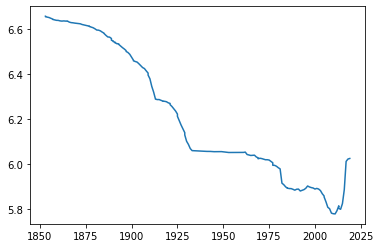

In [22]:
#plot

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(df2["year"], df2["mean_word_length"])


# Creating variables 

In [23]:
#Number of words in each speech
df2["word_count"] = df2["Speech_Parsed_3"].apply(lambda x : len(x))
df2["some_word_count"] = df2["Speech_Parsed_6"].apply(lambda x : len(x))

#Number of unique words in each speech
df2["unique_word"] = df2["Speech_Parsed_3"].apply(lambda x : len(set(x.lower().split()) ) )
df2["some_unique_word"] = df2["Speech_Parsed_6"].apply(lambda x : len(set(x.lower().split()) ) )

#Number of unique words ratio in each speech
df2["unique_word_ratio"] = df2.apply(lambda x : x["unique_word"]/x["word_count"] ,axis=1)
df2["some_unique_word_ratio"] = df2.apply(lambda x : x["some_unique_word"]/x["some_word_count"] ,axis=1)

In [24]:
print('Max word count', max(df2['word_count']))
print('Min word count', min(df2['word_count']))

Max word count 164834
Min word count 2951


In [25]:
# initialize tokenizer
#import nltk
#nltk.download('punkt')

from nltk import sent_tokenize, word_tokenize
#tokenizer = sent_tokenize

# Download positive and negative sentiment lexicons, split into words and convert to set representation. 
negative = set(requests.get('http://ptrckprry.com/course/ssd/data/negative-words.txt').text.split(';\n')[-1].split('\n'))
positive = set(requests.get('http://ptrckprry.com/course/ssd/data/positive-words.txt').text.split(';\n')[-1].split('\n'))
print(len(negative),len(positive))

4784 2007


In [26]:
# define function
def sent_preproc(string):
    return sent_tokenize(string.lower())

def word_preproc(string):
    return word_tokenize(string.lower())


In [27]:
# apply function
sentences = df2.Speech_Parsed_2.apply(sent_preproc)
words = df2.Speech_Parsed_2.apply(word_preproc)
some_words=df2.Speech_Parsed_6.apply(word_preproc)

df2['words']=words
df2['sentences']=sentences
df2['some_words']=some_words

## Mean Sentence Length

In [28]:
df2.loc[3]['sentences']

['    mr. speaker, mr. vice president, members of congress, my fellow americans: tonight marks the eighth year that i’ve come here to report on the state of the union.',
 'and for this final one, i’m going to try to make it a little shorter.',
 '(applause.)',
 'i know some of you are antsy to get back to iowa.',
 '(laughter.)',
 "i've been there.",
 "i'll be shaking hands afterwards if you want some tips.",
 '(laughter.)',
 'and i understand that because it’s an election season, expectations for what we will achieve this year are low.',
 'but, mr. speaker, i appreciate the constructive approach that you and the other leaderstook at the end of last year to pass a budget and make tax cuts permanent for working families.',
 'so i hope we can work together this year on some bipartisan priorities like criminal justice reform -- (applause) -- and helping people who are battling prescription drug abuse and heroin abuse.',
 '(applause.)',
 'so, who knows, we might surprise the cynics again.',


In [29]:
# calculating mean sentence length and adding to df

scount=[]
sentenceCount=0
letterCount=0


for i in range(0,len(df2)): 
    for sentence in df2.loc[i]['sentences']:
        import time
        # noz counting empty words:
        if len(sentence) > 0:
            letterCount=letterCount+len(sentence)
            sentenceCount=sentenceCount+1
    mean = letterCount/sentenceCount
    scount.append(mean)
    
df2['mean_sentence_length'] = scount

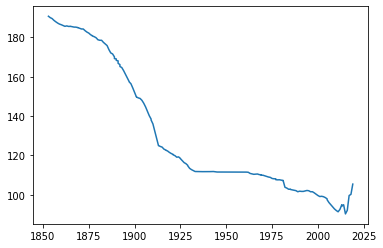

In [30]:
#plot

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(df2["year"], df2["mean_sentence_length"])

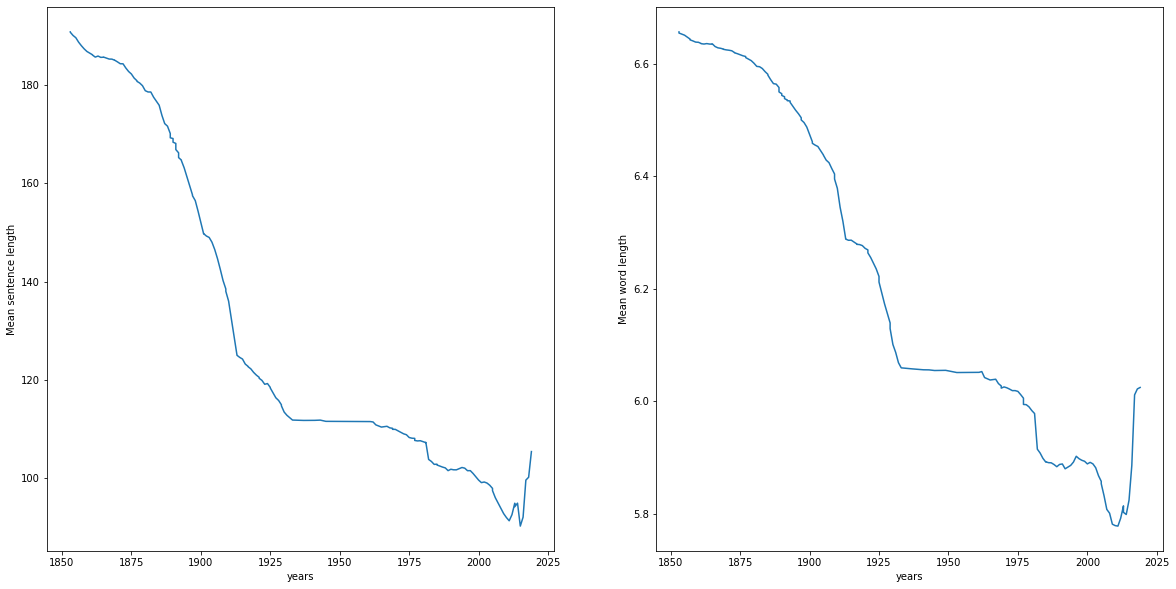

In [31]:
import matplotlib.pyplot as plt
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

fig, (ax1, ax2) = plt.subplots(1, 2)

#x = np.linspace(0, 10, 1000)
ax1.set(xlabel='years', ylabel='Mean sentence length')
ax1.plot(df2["year"], df2["mean_sentence_length"])

#x = np.linspace(0, 10, 1000)
ax2.set(xlabel='years', ylabel='Mean word length')
ax2.plot(df2["year"], df2["mean_word_length"])

In [32]:
# Defines function for counting number of matches with pos/neg words
def count_dictionary(tokenized_doc,dictionary):
    return len([word for word in tokenized_doc if word in dictionary])

In [33]:
df2['positive_words'] = some_words.apply(count_dictionary,dictionary=positive)
df2['negative_words'] = some_words.apply(count_dictionary,dictionary=negative)

# positive and negative words to total words ration
df2["positive_words_ratio"] = df2['positive_words']/df2['some_word_count']
df2["negative_words_ratio"] = df2['negative_words']/df2['some_word_count']

In [34]:
df2["words"]=words
df2["sentences"]=sentences

def count_word(array, word):
    return array.count(word)

df2['we_count'] = df2.words.apply(lambda a: count_word(a, 'we'))
#df2['our_count'] = df2.words.apply(lambda a: count_word(a, 'our'))
#df2['us_count'] = df2.words.apply(lambda a: count_word(a, 'us'))
#df2['america_count'] = df2.words.apply(lambda a: count_word(a, 'america'))
#df2['immigrants_count'] = df2.words.apply(lambda a: count_word(a, 'immigrants'))
#df2['black_count'] = df2.words.apply(lambda a: count_word(a, 'black'))
df2['war_count'] = df2.words.apply(lambda a: count_word(a, 'war'))
#df2['them_count'] = df2.words.apply(lambda a: count_word(a, 'them'))
df2['i_count'] = df2.words.apply(lambda a: count_word(a, 'i'))
#df2['united_count'] = df2.words.apply(lambda a: count_word(a, 'united'))
#df2['men_count'] = df2.words.apply(lambda a: count_word(a, 'men'))
#df2['women_count'] = df2.words.apply(lambda a: count_word(a, 'women'))
#df2['gender_count'] = df2.words.apply(lambda a: count_word(a, 'gender'))
#df2['job_count'] = df2.words.apply(lambda a: count_word(a, 'job'))
#df2['health_count'] = df2.words.apply(lambda a: count_word(a, 'health'))
#df2['china_count'] = df2.words.apply(lambda a: count_word(a, 'china'))
#df2['climate_count'] = df2.words.apply(lambda a: count_word(a, 'climate'))
#df2['moon_count'] = df2.words.apply(lambda a: count_word(a, 'moon'))


In [ ]:
# removing unused colmuns
df2.drop([ "Speech_Parsed_1", "Speech_Parsed_2", "Speech_Parsed_3", "Speech_Parsed_4", "Speech_Parsed_5", 
         "Speech_Parsed_6", "Date", "some_words", "Speech"], axis = 1, inplace = True)

In [35]:
df_sotu=df2.copy()
df_ia=df2.copy()
df_rep=df2.copy()
df_demo=df2.copy()
df_year=df2.copy()


In [36]:
indexNames = df_ia[df_ia['Type'] == 'State of the Union'].index
df_ia.drop(indexNames , inplace=True)
df_ia.to_csv("df_ia.csv", index=False)

indexNames = df_sotu[df_sotu['Type'] == 'Inaugural Address'].index
df_sotu.drop(indexNames , inplace=True)
df_sotu.to_csv("df_sotu.csv", index=False)


indexNames = df_rep[df_rep['Party'] == 'Democrat'].index
df_rep.drop(indexNames , inplace=True)
df_rep.to_csv("df_rep.csv", index=False)

indexNames = df_demo[df_demo['Party'] == 'Republican'].index
df_demo.drop(indexNames , inplace=True)
df_demo.to_csv("df_demo.csv", index=False)

indexNames = df_year[df_year['year'] < 1913].index
df_year.drop(indexNames , inplace=True)
df_year.to_csv("df_year.csv", index=False)

df2.to_csv("df2.csv", index=False)

In [42]:
df_year_sotu=df_year.copy()
df_year_ia=df_year.copy()

df_year_rep=df_year.copy()
df_year_demo=df_year.copy()

In [44]:
indexNames = df_year_ia[df_year_ia['Type'] == 'State of the Union'].index
df_year_ia.drop(indexNames , inplace=True)
df_year_ia.to_csv("df_year_ia.csv", index=False)

indexNames = df_year_sotu[df_year_sotu['Type'] == 'Inaugural Address'].index
df_year_sotu.drop(indexNames , inplace=True)
df_year_sotu.to_csv("df_year_sotu.csv", index=False)

indexNames = df_year_rep[df_year_rep['Party'] == 'Democrat'].index
df_year_rep.drop(indexNames , inplace=True)
df_year_rep.to_csv("df_year_rep.csv", index=False)

indexNames = df_year_demo[df_year_demo['Party'] == 'Republican'].index
df_year_demo.drop(indexNames , inplace=True)
df_year_demo.to_csv("df_year_demo.csv", index=False)

 # Table 

In [ ]:
# state of the union dataset
df_speech_des = df2.groupby('Type').describe().head()

In [ ]:
df_speech_des.head()

In [ ]:
#df_speech_des['word_count']
#with open('mytable.tex','w') as tf:
 #   tf.write(df_by_speech.to_latex())

# VADER 

In [ ]:
# passing our list of lists (i.e. 'sentences') to DataFrame
df_sent = pd.DataFrame(sentences)
df_sent

In [ ]:
# merging rows with sentences with the original DataFrame
s = df_sent.apply(lambda x: pd.Series(x['Speech_Parsed_2']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Sentences'
df3 = pd.concat([df2, s], axis=1)
#df3.head(1)

In [ ]:
#!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df3.loc[58]

In [ ]:
# using polarity_scores() to obtain the polarity indices for given sentence
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score

In [ ]:
vader_sent = df3['Sentences'].apply(sentiment_analyzer_scores)

In [ ]:
df3['vader_raw'] = vader_sent
df3['vader_neg'] = df3['vader_raw'].apply(lambda x: x['neg'])
df3['vader_pos'] = df3['vader_raw'].apply(lambda x: x['pos'])
df3['vader_neu'] = df3['vader_raw'].apply(lambda x: x['neu'])
df3['vader_com'] = df3['vader_raw'].apply(lambda x: x['compound'])


### The .tolist() thing below doesn't work - it kills our dataset


In [ ]:
# converting VADER series to DataFrame
# vader_sent_df = pd.DataFrame(vader_sent.tolist()).add_prefix('vader_')
# vader_sent_df.head()

In [ ]:
# merging new VADER dataframe with original dataframe
df3 = pd.concat([df2, vader_sent_df], axis=1)
df3.head()

In [ ]:
%matplotlib inline

# distribution of compound score (pos sent: compound score>=0.5)
df3['vader_compound'].plot(kind='hist')

In [ ]:
# plotting pos and neg scores: See both are present
df3.plot.scatter(x='vader_pos',y='vader_neg')

In [ ]:
df2.head()

In [ ]:
df3.to_csv("ml_model.csv", index = False)